In [174]:
import numpy as np
import os
import glob
import pandas as pd
from astropy.io import fits
from datetime import timedelta, date
from datetime import datetime
from alive_progress import alive_bar
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [2]:
import sys
sys.path.append('./src')

import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime

from FIESTA_functions import *
from HARPS_N_functions import *
from NEID_solar_functions import *
from functions import *

In [3]:
v_grid  = np.loadtxt('./lib/data_v4/v_grid.txt')
CCF     = np.loadtxt('./lib/data_v4/CCF.txt')
σCCF   = np.loadtxt('./lib/data_v4/σCCF.txt')
bjd     = np.loadtxt('./lib/data_v4/bjd.txt')
rv      = np.loadtxt('./lib/data_v4/rv.txt')
σrv     = np.loadtxt('./lib/data_v4/σrv.txt')
idx_rej = np.array(np.loadtxt('./lib/data_v4/idx_rej'), dtype=bool)


In [4]:
bjd = bjd[~idx_rej]
rv = rv[~idx_rej]
σrv = σrv[~idx_rej]

In [5]:
CCF_used_orders = np.load('./lib/CCF_used_orders.npy')
CCF_used_orders.shape

(31795, 37, 1604)

#### CCF_used_orders: (observations, orders, velocity grid)

In [6]:
CCF_used_orders = CCF_used_orders[~idx_rej,:,:]
CCF_used_orders.shape

(31145, 37, 1604)

#### Plot one observation

In [20]:
v_grid      = -100 + np.arange(1604)*0.25
idx_v       = (v_grid>87+2) & (v_grid<111-2)

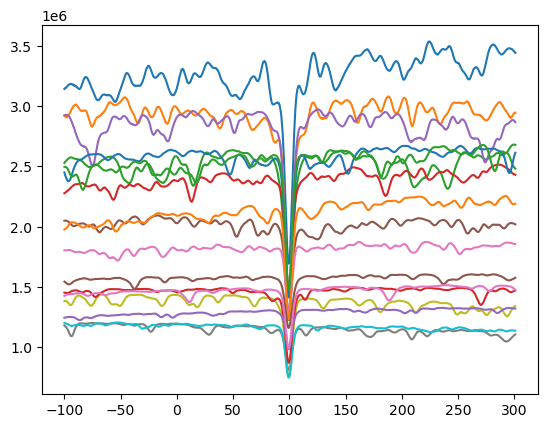

In [12]:
plt.plot(v_grid, CCF_used_orders[5244,:,:].T)
plt.show()

#### Get rid of the low flux orders

In [13]:
final_order_index = np.median(CCF_used_orders[0,:,:], axis=1) > 1e6
CCF_used_orders = CCF_used_orders[:,final_order_index,:]
CCF_used_orders.shape

(31145, 17, 1604)

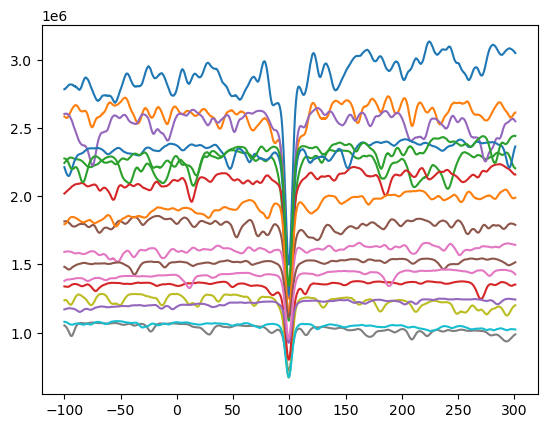

In [14]:
plt.plot(v_grid, CCF_used_orders[0,:,:].T)
plt.show()

#### correct the slope --> CCF_used_orders_nor

In [15]:
CCF_used_orders_nor = np.zeros(CCF_used_orders.shape)
for i in range(CCF_used_orders.shape[0]):
    for j in range(CCF_used_orders.shape[1]):
        reg                     = LinearRegression().fit(v_grid[~idx_v].reshape(-1,1), CCF_used_orders[i, j, ~idx_v])
        fitted_continuum        = reg.predict(v_grid.reshape(-1,1))
        CCF_used_orders_nor[i,j,:] =  CCF_used_orders[i, j,:] / fitted_continuum * np.median(fitted_continuum)

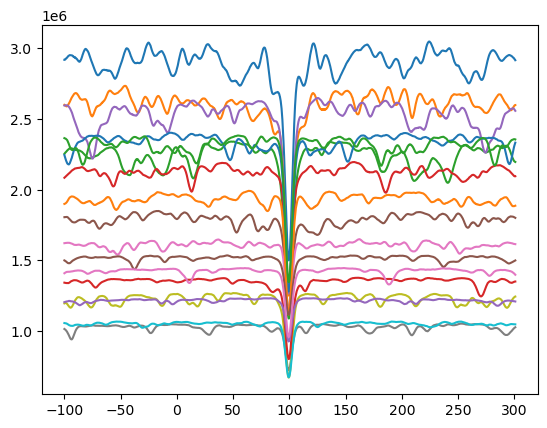

In [27]:
plt.plot(v_grid, CCF_used_orders_nor[0,:,:].T)
plt.show()

In [28]:
CCF_used_orders_nor.shape, idx_v.shape

((31145, 17, 1604), (1604,))

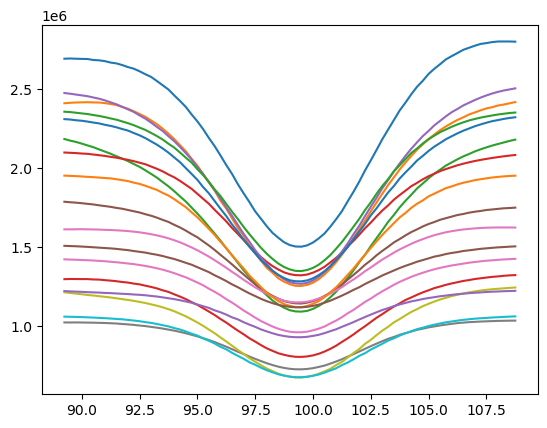

In [29]:
plt.plot(v_grid[idx_v], CCF_used_orders_nor[0,:,idx_v])
plt.show()

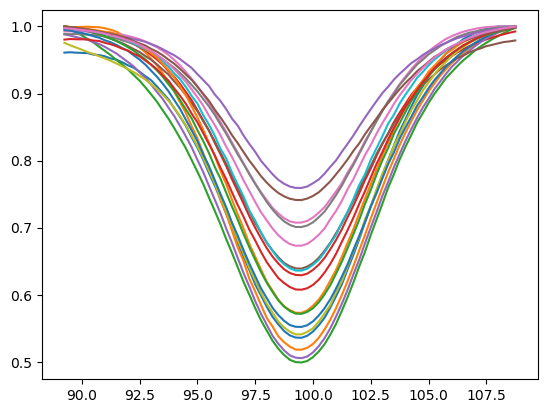

In [32]:
for i in range(CCF_used_orders_nor.shape[1]):
    plt.plot(v_grid[idx_v], CCF_used_orders_nor[0,i,idx_v]/np.max(CCF_used_orders_nor[0,i,idx_v]))
plt.show()

# for i in range(CCF_used_orders_nor.shape[1]):
#     plt.plot(v_grid[idx_v], CCF_used_orders_nor[0,i,idx_v]/np.median(CCF_used_orders_nor[0,i,idx_v]))
# plt.show()

In [45]:
v_grid = np.loadtxt('./lib/data_v4/v_grid.txt')
CCF_used_orders_nor = CCF_used_orders_nor[:,:,idx_v]

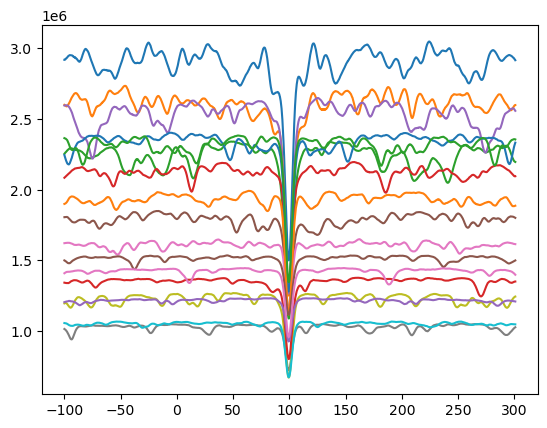

In [33]:
plt.plot(v_grid, CCF_used_orders_nor[0,:,:].T)
plt.show()

In [48]:
CCF_used_orders_nor.shape

(31145, 17, 1604)

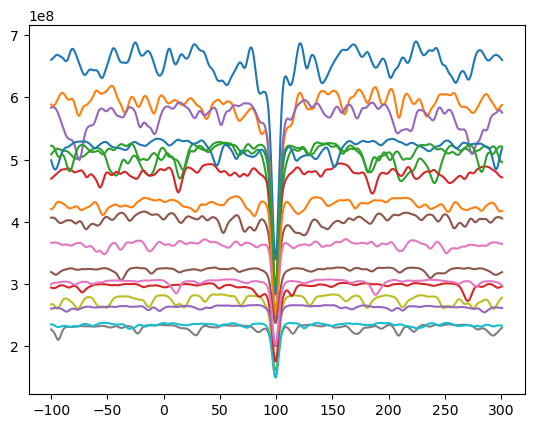

(17, 1604)

In [35]:
t_min = int(min(bjd))
t_max = int(max(bjd))
N = t_max -t_min + 1

CCF_order_daily     = np.zeros((CCF_used_orders_nor.shape[1], len(v_grid), N))
σCCF_order_daily    = np.zeros((CCF_used_orders_nor.shape[1], len(v_grid), N))

n = 0
idx = (bjd>(t_min+n)) & (bjd<(t_min+n+0.5))
plt.plot(v_grid, np.sum(CCF_used_orders_nor[idx,:,:], axis=0).T)
plt.show()
np.sum(CCF_used_orders_nor[idx,:,:], axis=0).shape


In [ ]:
t_min = int(min(bjd))
t_max = int(max(bjd))
N = t_max -t_min + 1

bjd_daily 			= np.zeros(N)
rv_daily			= np.zeros(N)
CCF_order_daily     = np.zeros((N, CCF_used_orders_nor.shape[1], len(v_grid)))
σCCF_order_daily    = np.zeros((N, CCF_used_orders_nor.shape[1], len(v_grid)))

for n in range(N):
    idx = (bjd>(t_min+n)) & (bjd<(t_min+n+0.5))
    if len(bjd[idx])!=0:
        rv_daily[n] =  weighted_avg_1D(rv[idx], 1/σrv[idx]**2)
        CCF_order_daily[n,:,:] = np.sum(CCF_used_orders_nor[idx,:,:], axis=0)
        σCCF_order_daily[n,:,:] = CCF_order_daily[n,:,:]**0.5
        if np.median(CCF_order_daily[n,:,:], axis=1).any() == 0:
            print(n)
        for j in range(CCF_order_daily.shape[1]):
            σCCF_order_daily[n,j,:] /= np.median(CCF_order_daily[n,j,~idx_v])
            CCF_order_daily[n,j,:] /= np.median(CCF_order_daily[n,j,~idx_v])
            
        # CCF_order_daily[n,:,:] = 1 - CCF_order_daily[n,:,:] / np.max(CCF_order_daily[n,:,:], axis=0)
        # σCCF_order_daily[n,:,:] = σCCF_order_daily[n,:,:] / np.max(CCF_order_daily[n,:,:], axis=0)

In [129]:
idx_0 		= (rv_daily==0)
rv_daily 	= rv_daily[~idx_0]
bjd_daily 	= bjd_daily[~idx_0]
CCF_order_daily 	= CCF_order_daily[~idx_0,:,:][:,:,idx_v]
σCCF_order_daily 	= σCCF_order_daily[~idx_0,:,:][:,:,idx_v]

In [131]:
print(
    idx_v.shape,
    rv_daily.shape,
    idx_0.shape,
    # CCF_used_orders_nor.shape, 
    CCF_order_daily.shape, 
    v_grid.shape, 
    # CCF_used_orders_nor[:,i,:].shape, 
    # np.sum(CCF_used_orders_nor[:,i,:],axis=0).shape,
    # np.sum(CCF_used_orders_nor[idx,:,:], axis=0).shape
)

(1604,) (202,) (357,) (202, 17, 79) (1604,)


#### save data 

In [139]:
np.save('./lib/FIESTA_daily_output_by_order/CCF_order_daily.npy', CCF_order_daily)
np.save('./lib/FIESTA_daily_output_by_order/σCCF_order_daily.npy', σCCF_order_daily)
np.savetxt('./lib/FIESTA_daily_output_by_order/v_grid.txt', v_grid[idx_v])

#### testing

In [138]:
CCF_order_daily.shape

(202, 17, 79)

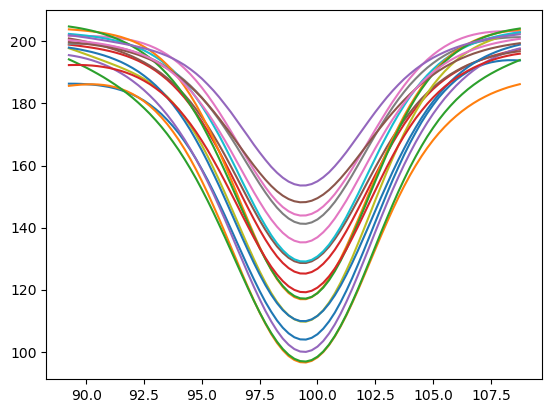

In [137]:
for i in range(CCF_order_daily.shape[1]):
    plt.plot(v_grid[idx_v], np.sum(CCF_order_daily[:,i,:],axis=0))
    # plt.title(str(i))
plt.show()

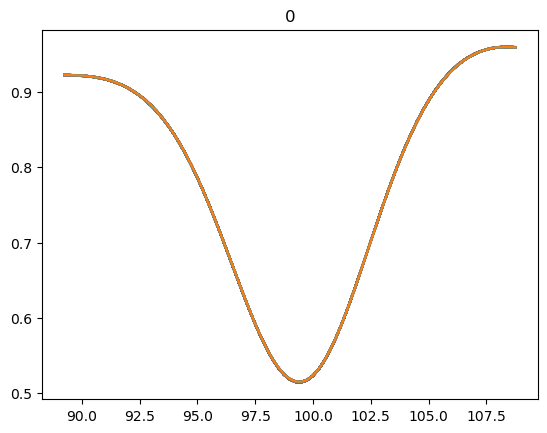

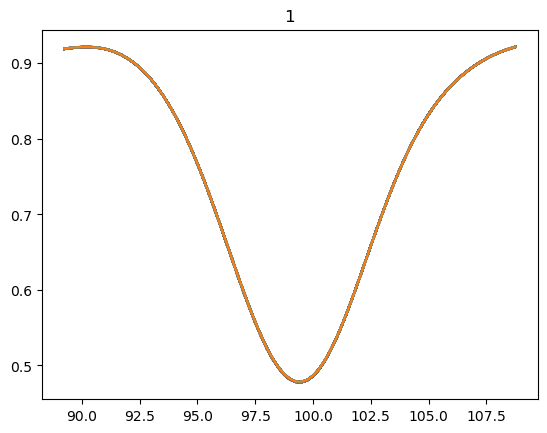

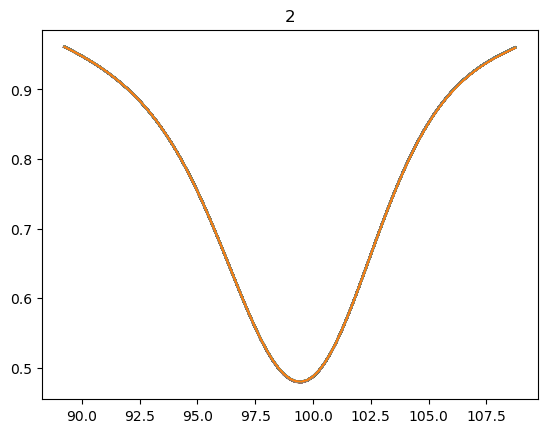

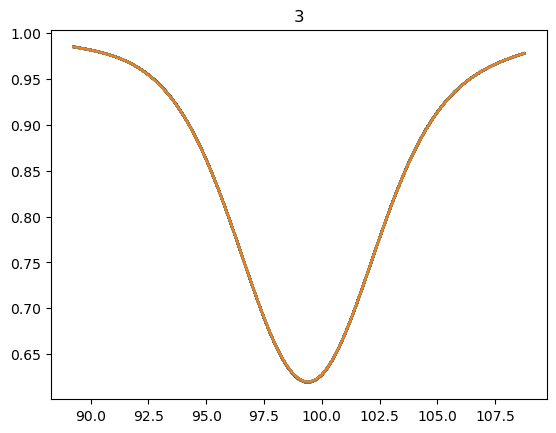

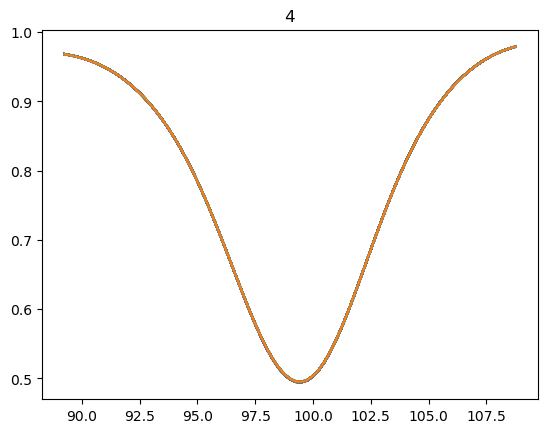

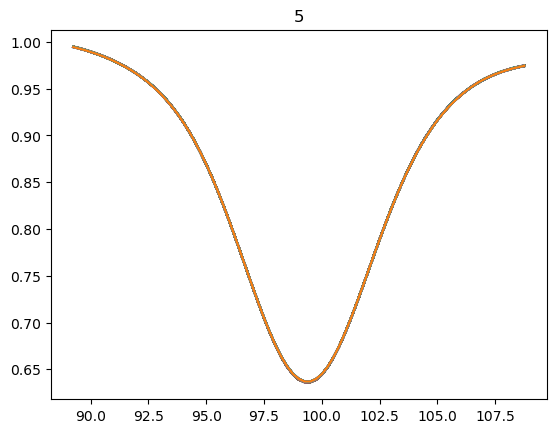

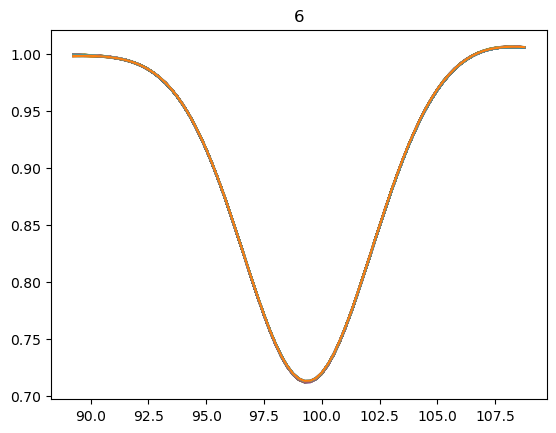

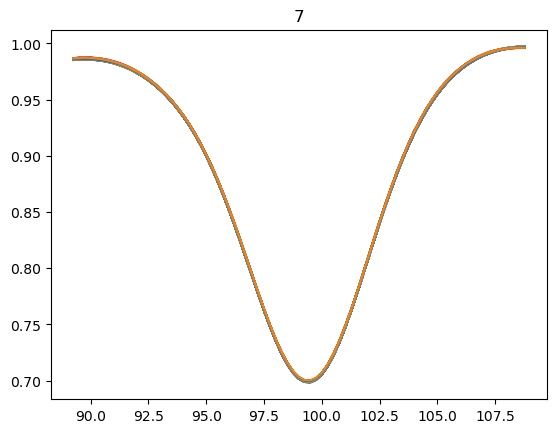

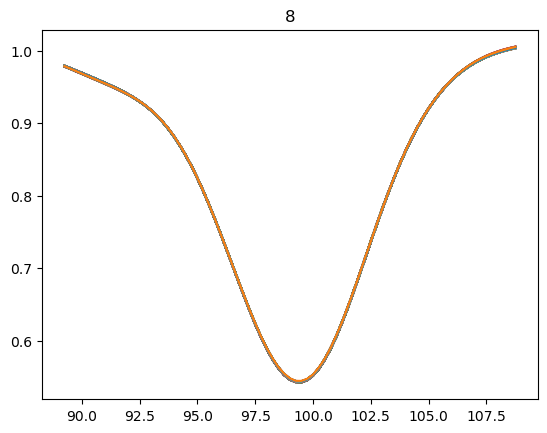

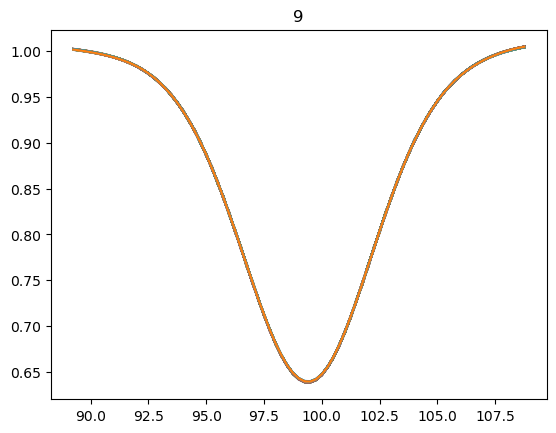

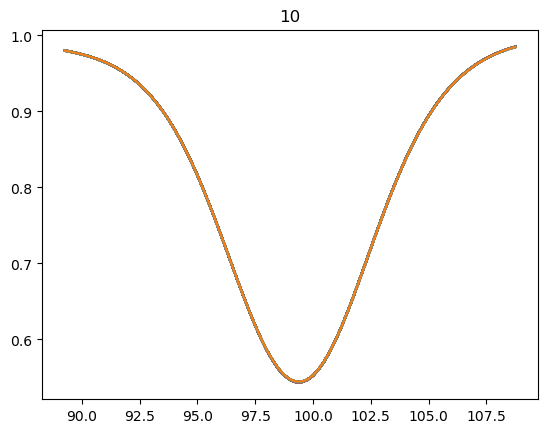

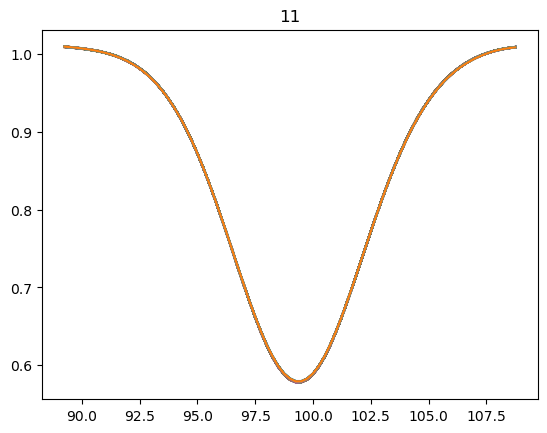

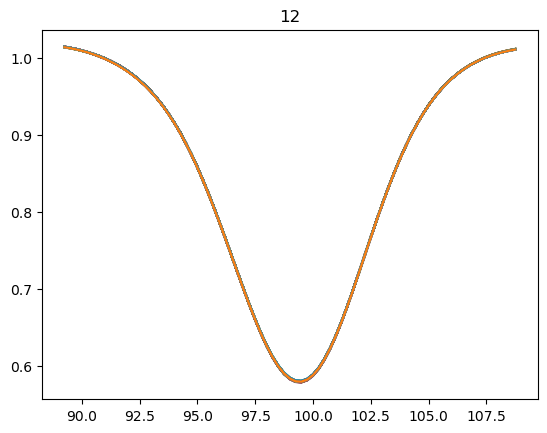

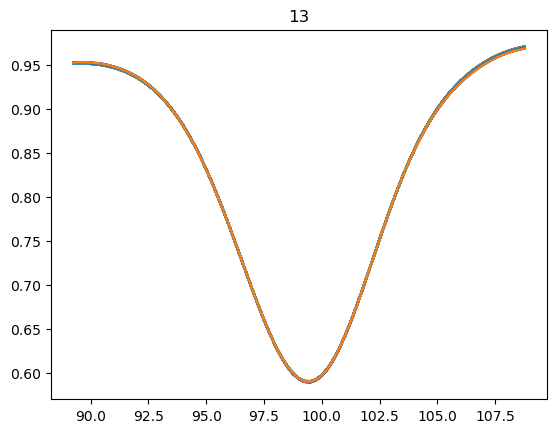

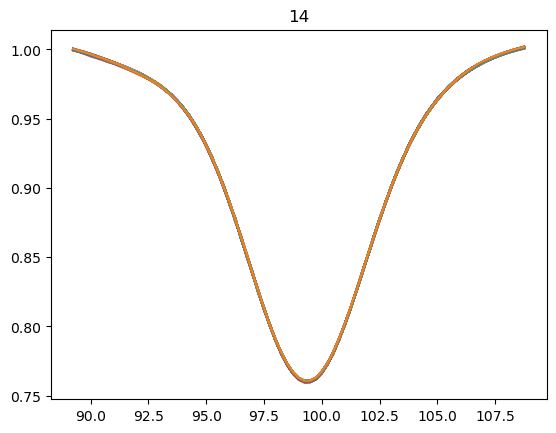

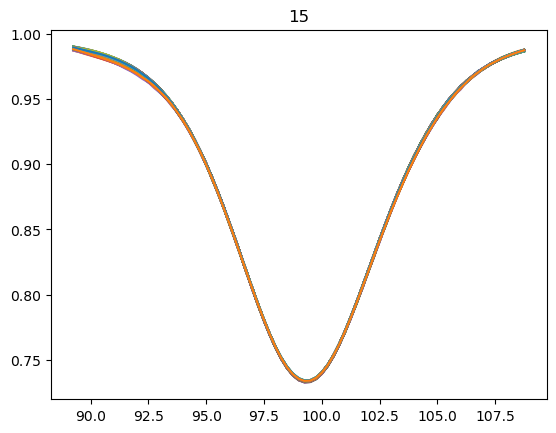

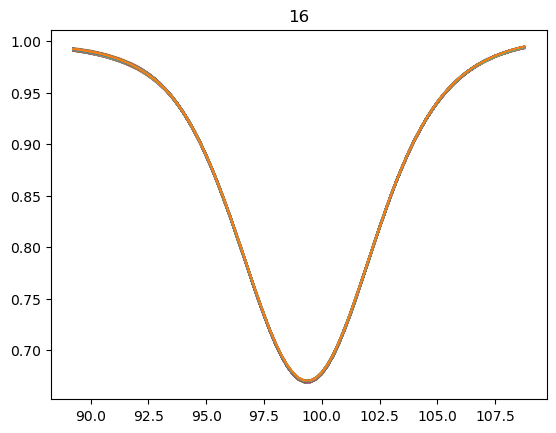

In [133]:
for i in range(CCF_order_daily.shape[1]):
    plt.plot(v_grid[idx_v], CCF_order_daily[:,i,:].T)
    plt.title(str(i))
    plt.show()

In [141]:
CCF_used_orders_nor.shape

(31145, 17, 1604)

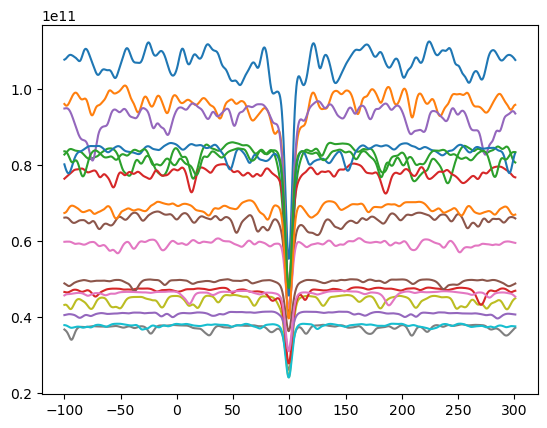

In [134]:
for i in range(CCF_used_orders_nor.shape[1]):
    plt.plot(v_grid, np.sum(CCF_used_orders_nor[:,i,:],axis=0))
    # plt.title(str(i))
plt.show()

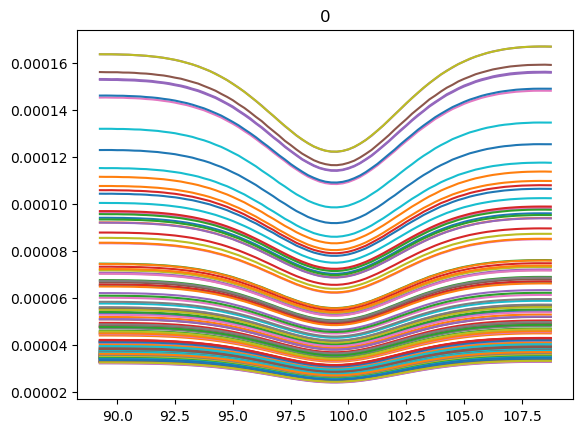

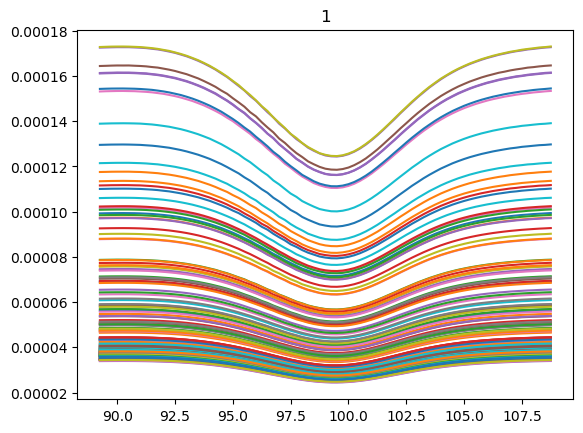

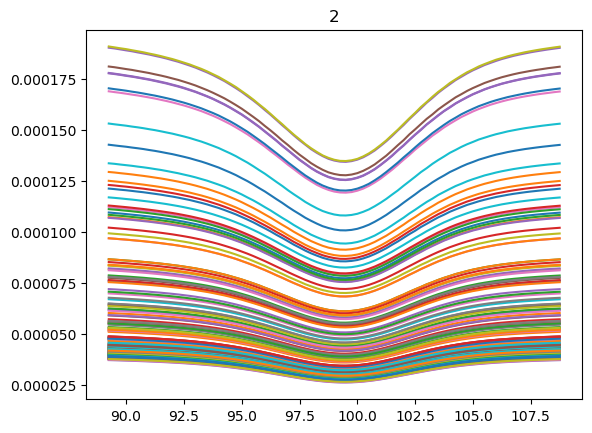

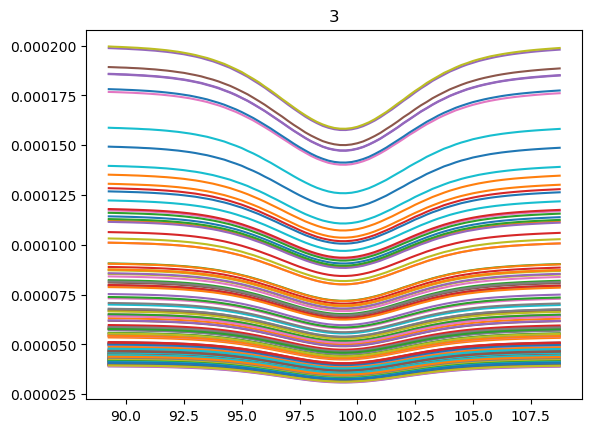

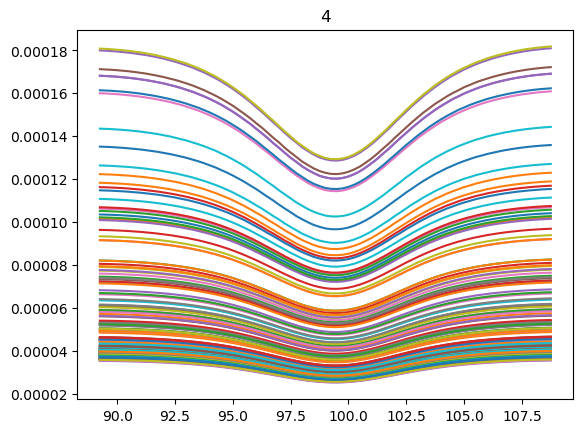

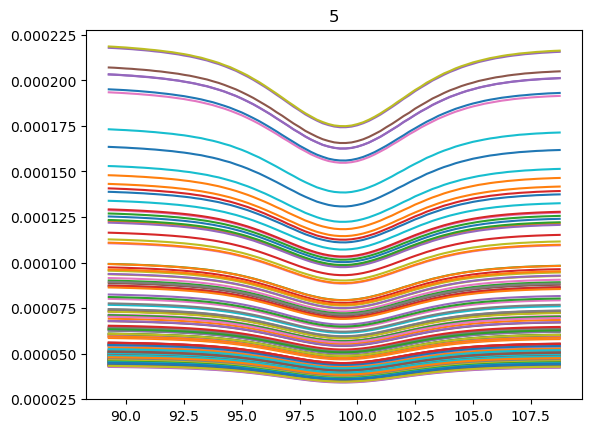

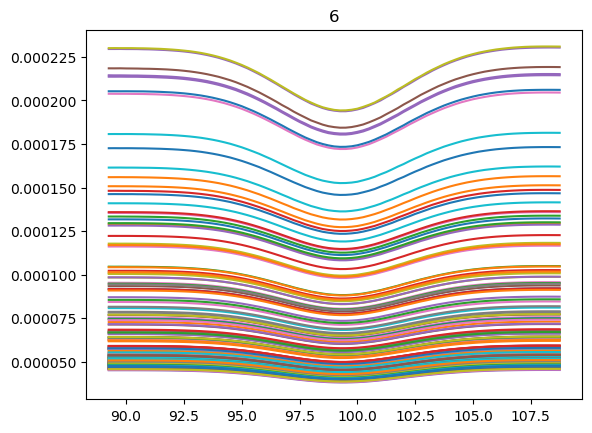

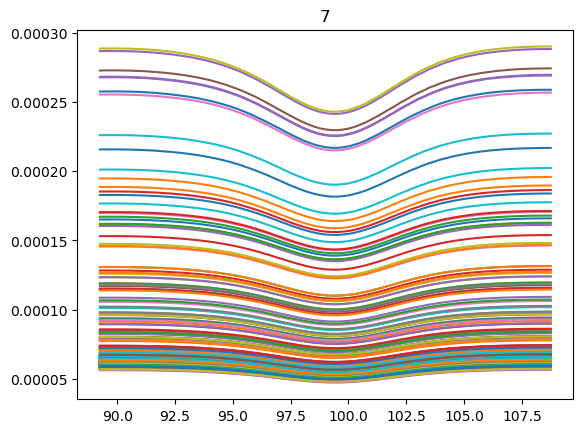

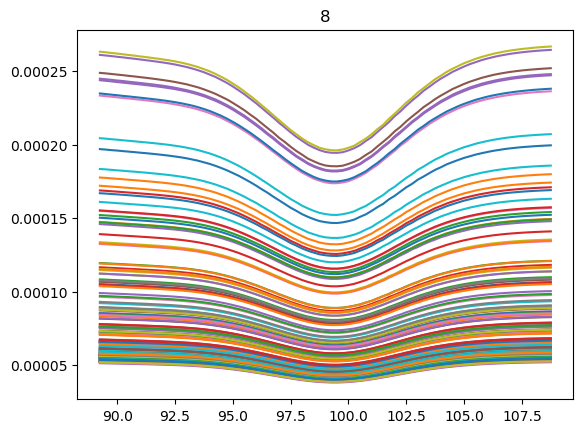

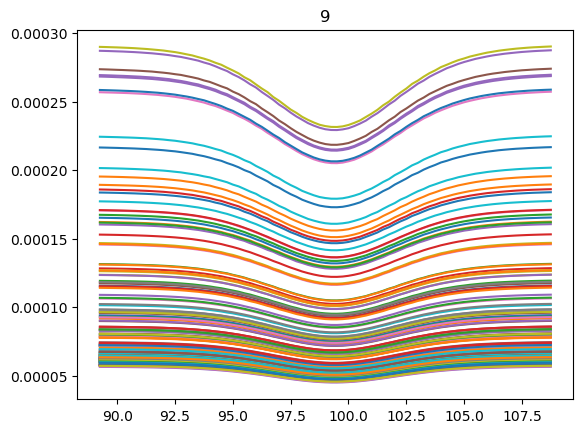

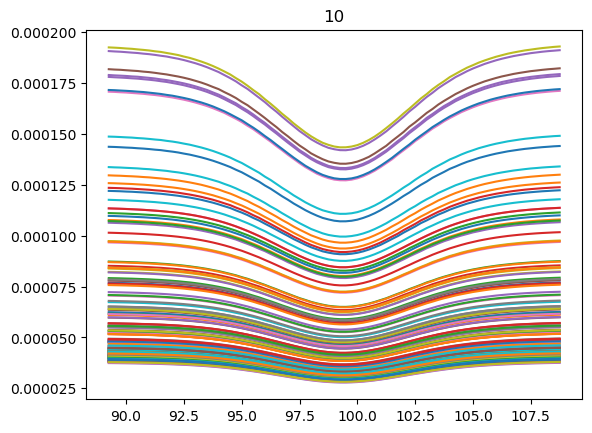

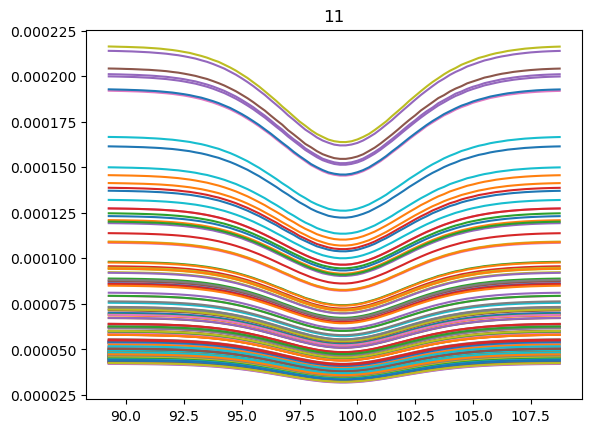

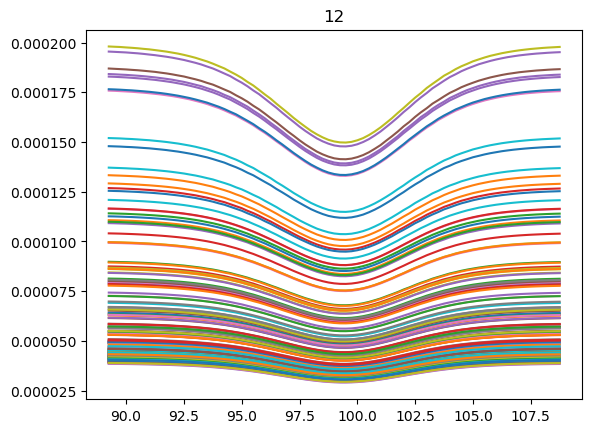

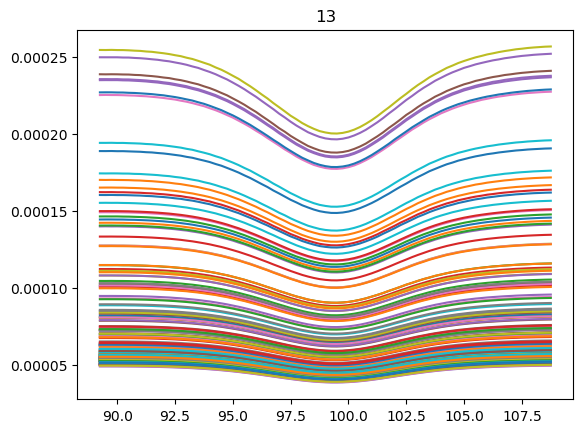

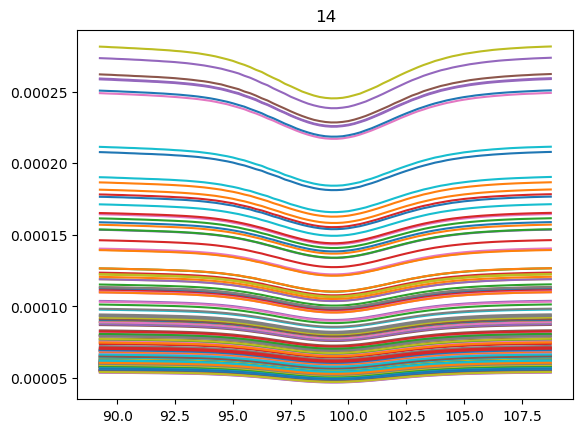

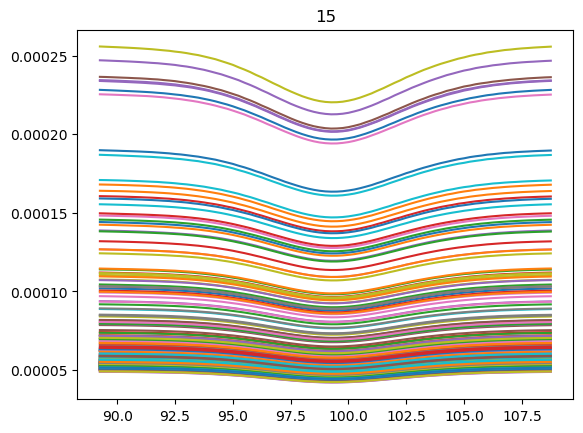

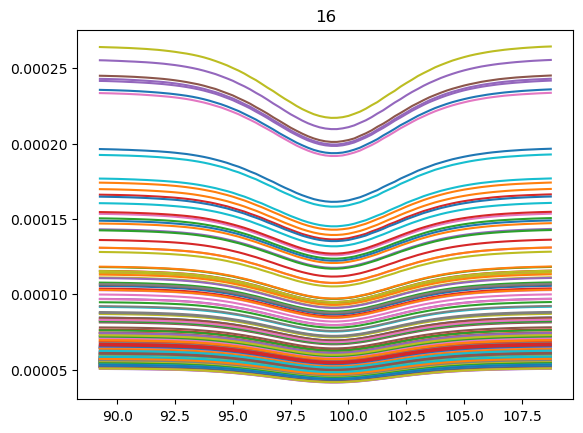

In [135]:
for i in range(CCF_order_daily.shape[1]):
    plt.plot(v_grid[idx_v], σCCF_order_daily[:,i,:].T)
    plt.title(str(i))
    plt.show()